# DM case
#### Diego Olaya - December 2020

### Load data

#### (1) Training and targeting sets

In [1]:
from ipynb.fs.full._init_ import *

xls = pd.ExcelFile('dataset.xlsx')
df_Soc_Dem = pd.read_excel(xls,'Soc_Dem').set_index('Client')
df_Products_ActBalance = pd.read_excel(xls,'Products_ActBalance').set_index('Client')
df_Inflow_Outflow = pd.read_excel(xls,'Inflow_Outflow').set_index('Client')
df_Sales_Revenues = pd.read_excel(xls,'Sales_Revenues').set_index('Client')

"""
Full dataset (n = 1615)
"""
data = pd.concat([df_Soc_Dem,df_Products_ActBalance,df_Inflow_Outflow,df_Sales_Revenues], axis=1)

"""
Training set: dataset reduced to only instances with information on sales + revenues
"""
df_training = data.dropna(subset=['Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL'])
print("Dimensions training set: ", df_training.shape)
"""
Target set
"""
df_target = data.iloc[[index for index in list(data.index) if index not in list(df_training.index)],:]
print("Dimensions targeting set: ", df_target.shape)


Dimensions training set:  (969, 35)
Dimensions targeting set:  (646, 35)


In [ ]:
pip freeze > requirements.txt

### Preprocessing

In [3]:
"""
Descriptive table
"""
desc_table = info_table(data)
desc_table

,Type,Min,Max,Mean,STD,Unique,Zero Values,Missing Values,% Missing Values,mode
Age,int64,0,97,42.849,18.551,94,1,0,0.000,39
Tenure,int64,0,273,101.34,64.917,248,19,0,0.000,150
Count_CA,int64,1,4,1.079,0.333,4,0,0,0.000,1
TransactionsCred,float64,0,63,5.542,6.355,46,14,28,1.734,2
VolumeDebCash_Card,float64,0,23571.4,257.937,757.734,262,631,28,1.734,0
VolumeDebCashless_Card,float64,0,3637.62,150.85,311.939,875,705,28,1.734,0
VolumeDeb_PaymentOrder,float64,0,72278.8,715.975,3215.11,1067,435,28,1.734,0
TransactionsDeb,float64,0,102,16.007,16.244,87,66,28,1.734,1
TransactionsDeb_CA,float64,0,83,13.597,12.975,72,72,28,1.734,1
TransactionsDebCash_Card,float64,0,25,1.989,2.711,20,631,28,1.734,0


In [4]:
"""
Drop columns with large percentage of missing values
"""
col_drop = list(desc_table[(desc_table['% Missing Values'] > 70)].index)
print("Names of removed columns: ",col_drop)
print('Number of removed columns: ',len(col_drop))
context = [variable for variable in list(df_training.columns) if variable not in col_drop] 

Names of removed columns:  ['ActBal_CL', 'ActBal_CC', 'ActBal_OVD', 'ActBal_MF', 'ActBal_SA', 'Count_CL', 'Count_CC', 'Count_OVD', 'Count_MF', 'Count_SA']
Number of removed columns:  10


In [6]:
"""
Dummy treatment for 'sex'
"""
df_training['Sex'] = np.where(df_training['Sex'] == 'M',1,0)
df_target['Sex'] = np.where(df_target['Sex'] == 'M',1,0)

### Models
#### (2) 3 propensity models: consumer loan, credit card and mutual fund.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def data_parser(data,df_Sales_Revenues,col_outcome):
    """
    Drop columns with large percentage of missing values
    """
    desc_table = info_table(data)
    col_drop = list(desc_table[(desc_table['% Missing Values'] > 70)].index)
    col_drop.extend([outcome for outcome in list(df_Sales_Revenues.columns) if outcome not in col_outcome])
    names_context = [variable for variable in list(data.columns) if variable not in col_drop]
    names_context = [variable for variable in names_context if variable not in col_outcome]
    
    """
    Imput missing data with median 
    """
    for column in names_context:
        col_median = data.loc[:,column].median()
        data[column] = data[column].fillna(col_median) 
        
    context = data[names_context] 
    client = data.index
    outcome = data[col_outcome]
    return (context.values,client.values,outcome.values,names_context)

class Train:
    def __init__(self, data_training, data_target,data_parser,df_Sales_Revenues,col_outcome,train_ratio=.7):
        self.data_training = shuffle(data_training,random_state=0)
        self.data_target = data_target
        self.data_parser = data_parser
        self.col_outcome = col_outcome
        self.df_Sales_Revenues = df_Sales_Revenues
        self.train_ratio = train_ratio
        
        """
        Train-test split
        """
        self.train_data, self.test_data = train_test_split(self.data_training, test_size=(1-train_ratio), random_state=0, stratify=self.data_training[[col_outcome]])
        
        self.c_tr, self.id_tr, self.o_tr, self.names_context = self.data_parser(self.train_data,self.df_Sales_Revenues, self.col_outcome)
        self.c_te, self.id_te, self.o_te, self.names_context = self.data_parser(self.test_data,self.df_Sales_Revenues, self.col_outcome)
        
        self.c_target, self.id_target, self.o_target, self.names_context = self.data_parser(self.data_target,self.df_Sales_Revenues, self.col_outcome)

        self.td_tr = np.concatenate((self.c_tr, np.array([self.id_tr]).T,np.array([self.o_tr]).T), axis=1)
        self.td_te = np.concatenate((self.c_te, np.array([self.id_te]).T,np.array([self.o_te]).T), axis=1)
        self.td_target = np.concatenate((self.c_target, np.array([self.id_target]).T,np.array([self.o_target]).T), axis=1)
        
        self.colnames = self.names_context.copy()
        self.non_c = ['client',self.col_outcome]
        self.colnames.extend(self.non_c)
                
        self.df_tr = pd.DataFrame(data=self.td_tr, columns=self.colnames)
        self.df_te = pd.DataFrame(data=self.td_te, columns=self.colnames)
        self.df_target = pd.DataFrame(data=self.td_target, columns=self.colnames)

        self.param_tuning = {
            'max_depth': [3, 5, 7, 10], # The maximum depth of the tree.
            'n_estimators' : [100,200,500], 
            'max_features': ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split (sqrt(n_features) and log2(n_features))
            'criterion' :['gini', 'entropy'], # The function to measure the quality of a split. Gini impurity (0 if only one class, What’s the probability we classify the datapoint incorrectly) and information gain (how much Entropy we removed->how much variance the data has).
            'random_state': [0]
        }
        
    def m_sup(self):
        """
        Training and performance on training set
        """
        est = GridSearchCV(estimator = RandomForestClassifier(), param_grid = self.param_tuning,cv = 5,n_jobs = -1,verbose = 1)
        m_fit = est.fit(self.df_tr[self.names_context],self.df_tr[self.col_outcome])
        prob = m_fit.predict_proba(self.df_te[self.names_context])[::,1]
        fpr, tpr, _ = roc_curve(self.df_te[self.col_outcome], prob)
        auc = roc_auc_score(self.df_te[self.col_outcome], prob)
        fea_imp = pd.DataFrame(m_fit.best_estimator_.feature_importances_,
                               index = self.names_context,
                               columns = ['importance'])
        fea_imp = fea_imp.sort_values(by = ["importance"], ascending = False)

        """
        Predicting propensities on target set
        """
        target_index = self.df_target.index.values
        prob_target = m_fit.predict_proba(self.df_target[self.names_context])[::,1]
        df_prob_target = pd.DataFrame(prob_target,target_index, columns = {"Prob_"+self.col_outcome})
        predictions = pd.concat([self.df_target,df_prob_target],axis = 1)
        
        summary = {'model':m_fit,
                   'par_best_m':m_fit.best_params_,
                   'auc':auc,
                   'fe_importance':fea_imp,
                   'predictions':predictions}
        
        return summary

#### Consumer loan predictions

In [7]:
# train_cl = Train(df_training,df_target,data_parser,df_Sales_Revenues,'Sale_CL')        
# pred_cl = train_cl.m_sup()
"""
Save results
"""
# dump(pred_cl,'pred_cl.sav')
"""
Load results
"""
pred_cl = load('pred_cl.sav')
pred_cl

{'model': GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 7, 10],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 200, 500], 'random_state': [0]},
              verbose=1),
 'par_best_m': {'criterion': 'entropy',
  'max_depth': 5,
  'max_features': 'auto',
  'n_estimators': 100,
  'random_state': 0},
 'auc': 0.6328600405679513,
 'fe_importance':                               importance
 Tenure                          0.153814
 Age                             0.143766
 ActBal_CA                       0.072669
 VolumeDeb_CA                    0.061380
 VolumeCred_CA                   0.060205
 VolumeDeb_PaymentOrder          0.060003
 TransactionsDeb_PaymentOrder    0.045072
 TransactionsCred                0.044642
 VolumeDeb                       0.042973
 TransactionsDeb                 0.041461

#### Credit card predictions

In [8]:
# train_cc = Train(df_training,df_target,data_parser,df_Sales_Revenues,'Sale_CC')  
# pred_cc = train_cc.m_sup()
"""
Save results
"""
# dump(pred_cc,'pred_cc.sav')
"""
Load results
"""
pred_cc = load('pred_cc.sav')
pred_cc

{'model': GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 7, 10],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 200, 500], 'random_state': [0]},
              verbose=1),
 'par_best_m': {'criterion': 'gini',
  'max_depth': 7,
  'max_features': 'auto',
  'n_estimators': 100,
  'random_state': 0},
 'auc': 0.5953248711826065,
 'fe_importance':                               importance
 ActBal_CA                       0.134982
 Age                             0.083033
 VolumeCred_CA                   0.071138
 VolumeDeb_PaymentOrder          0.067397
 VolumeDeb_CA                    0.065197
 VolumeCred                      0.060657
 VolumeDeb                       0.056936
 Tenure                          0.053534
 VolumeDebCash_Card              0.051103
 TransactionsDebCash_Card        0.051005
 V

#### Mutual funds predictions

In [9]:
# train_mf = Train(df_training,df_target,data_parser,df_Sales_Revenues,'Sale_MF') 
# pred_mf = train_mf.m_sup()
"""
Save results
"""
# dump(pred_mf,'pred_mf.sav')
"""
Load results
"""
pred_mf = load('pred_mf.sav')
pred_mf

{'model': GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 7, 10],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 200, 500], 'random_state': [0]},
              verbose=1),
 'par_best_m': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'auto',
  'n_estimators': 200,
  'random_state': 0},
 'auc': 0.6006363770904247,
 'fe_importance':                               importance
 ActBal_CA                       0.081954
 VolumeCred_CA                   0.077782
 VolumeCred                      0.076084
 VolumeDeb                       0.072673
 Age                             0.069109
 TransactionsDeb                 0.063926
 TransactionsDebCashless_Card    0.063669
 Tenure                          0.062172
 VolumeDeb_CA                    0.061290
 VolumeDeb_PaymentOrder          0.054762
 

### Target optimization

#### Which clients have higher propensity to buy consumer loan?

In [ ]:
sns.regplot(x=pred_cl['predictions']['Prob_Sale_CL'], y=pred_cl['predictions']['Age'], line_kws={"color":"r","alpha":0.7,"lw":5})

#### Which clients have higher propensity to buy credit card?

In [ ]:
sns.regplot(x=pred_cc['predictions']['Prob_Sale_CC'], y=pred_cc['predictions']['Age'], line_kws={"color":"r","alpha":0.7,"lw":5})

#### Which clients have higher propensity to buy mutual fund?

In [ ]:
sns.regplot(x=pred_mf['predictions']['Prob_Sale_MF'], y=pred_mf['predictions']['TransactionsCred_CA'], line_kws={"color":"r","alpha":0.7,"lw":5})

#### Which clients are to be targeted with which offer? General description.

In [10]:
"""
Index clients to target
"""
target_index = df_target.index.values
df_Prob_Sale_CL = pd.DataFrame(pred_cl['predictions']['Prob_Sale_CL'],columns = {"Prob_Sale_CL"}).set_index(target_index)
df_Prob_Sale_CC = pd.DataFrame(pred_cc['predictions']['Prob_Sale_CC'], columns = {"Prob_Sale_CC"}).set_index(target_index)
df_Prob_Sale_MF = pd.DataFrame(pred_mf['predictions']['Prob_Sale_MF'], columns = {"Prob_Sale_MF"}).set_index(target_index)
"""
Summary table
"""
summary_df_target = pd.concat([df_target,
                      df_Prob_Sale_CL,
                      df_Prob_Sale_CC,
                      df_Prob_Sale_MF],axis =1,ignore_index=False)
summary_df_target['Offer_name'] = summary_df_target[['Prob_Sale_CL','Prob_Sale_CC','Prob_Sale_MF']].idxmax(axis=1)
summary_df_target['Offer_propensity'] = summary_df_target[['Prob_Sale_CL','Prob_Sale_CC','Prob_Sale_MF']].max(axis=1)
"""
Sorted summary table
"""
summary_df_target_sorted = summary_df_target.sort_values(by = ["Offer_propensity"], ascending = False)
"""
Subset of clients to target
"""
df_4_offer = summary_df_target_sorted.head(round(0.15*len(summary_df_target_sorted))) 


In [19]:
df_4_offer

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Prob_Sale_CL,Prob_Sale_CC,Prob_Sale_MF,Offer_name,Offer_propensity
1091,0,42,174,1,1.0,26.0,NaN,NaN,NaN,7.107143,...,0.0,1.0,4.910714,0.000000,10.107143,0.399696,0.199554,0.823311,Prob_Sale_MF,0.823311
556,1,39,160,1,NaN,NaN,NaN,NaN,NaN,227.262143,...,0.0,0.0,4.179286,0.000000,0.000000,0.263074,0.082454,0.810847,Prob_Sale_MF,0.810847
102,1,20,172,1,NaN,NaN,1.0,NaN,NaN,48.771071,...,0.0,1.0,2.958036,0.000000,6.952500,0.533754,0.111217,0.810502,Prob_Sale_MF,0.810502
725,0,31,74,1,NaN,20.0,NaN,NaN,NaN,374.224286,...,0.0,0.0,2.594464,0.000000,0.000000,0.270581,0.187286,0.788428,Prob_Sale_MF,0.788428
1230,0,45,20,1,NaN,1.0,1.0,1.0,NaN,3.109286,...,0.0,0.0,1.547500,0.000000,0.000000,0.373178,0.138120,0.780644,Prob_Sale_MF,0.780644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,0,23,111,1,NaN,NaN,NaN,NaN,NaN,4.249643,...,0.0,1.0,0.000000,0.000000,8.952143,0.473651,0.152579,0.146052,Prob_Sale_CL,0.473651
852,1,30,199,1,NaN,NaN,NaN,NaN,NaN,357.145714,...,NaN,NaN,NaN,NaN,NaN,0.471896,0.213231,0.154999,Prob_Sale_CL,0.471896
126,0,33,173,1,NaN,NaN,1.0,NaN,NaN,70.799643,...,NaN,NaN,NaN,NaN,NaN,0.469236,0.276297,0.291000,Prob_Sale_CL,0.469236
1134,0,35,96,1,NaN,NaN,1.0,NaN,1.0,2534.983571,...,NaN,NaN,NaN,NaN,NaN,0.466673,0.173651,0.394704,Prob_Sale_CL,0.466673


In [14]:
"""
Clients to offer CC
"""
clients_cc = df_4_offer[df_4_offer["Offer_name"] == "Prob_Sale_CC"]

"""
Impute revenue:
"""
clients_cc['Revenue_CC'] = clients_cc['Revenue_CC'].fillna(clients_cc.loc[:,'Revenue_CC'].median()) 
clients_cc['Exp_Revenue_CC'] = clients_cc['Revenue_CC']*clients_cc['Offer_propensity']

print('Expected revenue CC: ',clients_cc['Exp_Revenue_CC'].sum())
# print(clients_cc.describe())

Expected revenue CC:  94.34600285573832


In [15]:
"""
Clients to offer CL
"""
clients_cl = df_4_offer[df_4_offer["Offer_name"] == "Prob_Sale_CL"]

"""
Impute revenue:
"""
clients_cl['Revenue_CL'] = clients_cl['Revenue_CL'].fillna(clients_cl.loc[:,'Revenue_CL'].median()) 
clients_cl['Exp_Revenue_CL'] = clients_cl['Revenue_CL']*clients_cl['Offer_propensity']

print('Expected revenue CL: ',clients_cl['Exp_Revenue_CL'].sum())
# print(clients_cl.describe())

Expected revenue CL:  143.1811172378194


In [16]:
"""
Clients to offer MF
"""
clients_mf = df_4_offer[df_4_offer["Offer_name"] == "Prob_Sale_MF"]

"""
Impute revenue:
"""
clients_mf['Revenue_MF'] = clients_mf['Revenue_MF'].fillna(clients_mf.loc[:,'Revenue_MF'].median()) 
clients_mf['Exp_Revenue_MF'] = clients_mf['Revenue_MF']*clients_mf['Offer_propensity']

print('Expected revenue MF: ',clients_mf['Exp_Revenue_MF'].sum())
# print(clients_mf.describe())

Expected revenue MF:  213.26581548173544


### List of clients to contact

In [ ]:
df_4_offer['client'] = df_4_offer.index.values
clients_to_contact = df_4_offer[['client','Offer_name','Offer_propensity']]

"""
Export to excel list of clients to target
"""
clients_to_contact.to_excel('clients_to_contact.xlsx', index=False)

### Revenue plot

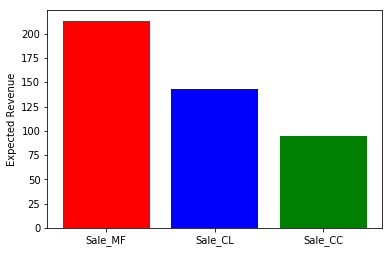

In [17]:
height = [clients_mf['Exp_Revenue_MF'].sum(), clients_cl['Exp_Revenue_CL'].sum(),clients_cc['Exp_Revenue_CC'].sum()]
bars = ('Sale_MF','Sale_CL','Sale_CC')

y_pos = np.arange(len(bars))
plt.bar(y_pos, height,color=['red', 'blue', 'green'])
plt.xticks(y_pos, bars)
plt.ylabel('Expected Revenue')
plt.show()